# Data Exploration

I start exploring a subset of the entire Google BigQuery dataset for the NDT server `4.71.210.211` based in Atlanta, Georgia, USA.

In [33]:
options(jupyter.plot_mimetypes = 'image/png')
library(plyr)
library(ggplot2)

In [22]:
# Load the combined dataset
df <- read.csv('NDTdata/combined_data.csv',stringsAsFactors=FALSE)

# There are extra rows from the headers of the original BigQuery csv files. I need to drop these rows.
df$avgrtt <- as.numeric(df$avgrtt) #this will give NA for the header rows
df <- df[!is.na(df$avgrtt),]

# Now convert the numerical columns to numbers
df$tempcount<-1
df$daytime  <- df$datetime;
df$asdate  <- as.POSIXct(strptime(df$datetime, "%Y-%m-%dT%H:%M:%S"));
df$dataday<-format(df$asdate, "%Y%m%d")
df$countrtt <- as.integer(df$countrtt)
df$sumrtt <- as.integer(df$sumrtt)
df$countrtt <- as.integer(df$countrtt)
df$clientlat <- as.numeric(df$client_lat)
df$clientlon <- as.numeric(df$client_lon)
str(df)

Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"

'data.frame':	64000 obs. of  16 variables:
 $ datetime  : chr  "2016-01-01T00:03:51" "2016-01-01T00:21:50" "2016-01-01T00:22:30" "2016-01-01T00:26:29" ...
 $ serverip  : chr  "4.71.210.211" "4.71.210.211" "4.71.210.211" "4.71.210.211" ...
 $ clientip  : chr  "187.75.48.135" "181.64.207.113" "100.13.53.65" "65.113.89.153" ...
 $ clientport: chr  "46475" "12677" "42441" "15636" ...
 $ client_lat: chr  "-23.549999237060547" "-12.043299674987793" "28.152099609375" "17.73419952392578" ...
 $ client_lon: chr  "-46.93330001831055" "-77.0282974243164" "-82.52300262451172" "-64.73470306396484" ...
 $ countrtt  : int  94 5433 5373 1168 2839 252 2550 366 1705 1734 ...
 $ sumrtt    : int  92511 1055251 185809 860339 355271 46142 40397 296161 57266 289557 ...
 $ avgrtt    : num  984.2 194.2 34.6 736.6 125.1 ...
 $ clientsub : chr  "187.75.48.0" "181.64.207.0" "100.13.53.0" "65.113.89.0" ...
 $ tempcount : num  1 1 1 1 1 1 1 1 1 1 ...
 $ daytime   : chr  "2016-01-01T00:03:51" "2016-01-01T00:21:50" "

We now apply the ninsub, avginsub, and sigmainsub calculations as well as calculating the datafrequency and whether the points are outliers.

In [34]:
cumavg <- function( x ){

    lx <- length(x)
    
    nmean <-1
    nmean[1] <- x[1]
    if (lx > 1){
        updatevals <- c( 2:lx )
        for(k in updatevals){
            nmean[k] <- (nmean[k-1] * (k-1) + x[k])/k
        }
    }
    return(nmean)

    invisible()
}

cumsigma <- function( x ){
    lx <- length(x)
    
    nvar <- nmean <-1
    nvar[1]  <- 0.0
    nmean[1] <- x[1]
    if (lx > 1){
        updatevals <- c( 2:lx )
        for(k in updatevals){
            nmean[k] <- (nmean[k-1] * (k-1) + x[k])/k
            nvar[k] <- ((nvar[k-1] + nmean[k-1]*nmean[k-1])*(k-1) + x[k]*x[k] )/k - nmean[k]*nmean[k]   
        }
    }
    return(sqrt(nvar))

    invisible()

}

outliertest <- function( x, epsilon=0.75 ){
    #epsilon is the threshold above which we consider a point an outlier. Typically 0.75
    #we only consider outliers if the point is above the average (not below) since we are interested in high network traffic
    lx <- length(x)
    nvar <- nmean <- outliers <-1
    nvar[1]  <- 0.0
    nmean[1] <- x[1]
    outliers[1] <- 0 #by definition the first one is not an outlier
    if (lx > 1){
        updatevals <- c( 2:lx )
        for(k in updatevals){

            nmean[k] <- (nmean[k-1] * (k-1) + x[k])/k
            nvar[k] <- ((nvar[k-1] + nmean[k-1]*nmean[k-1])*(k-1) + x[k]*x[k] )/k - nmean[k]*nmean[k]
            if (k==2){
                outliers[k] <- 0
            } else {
                if (nvar[k] > 0){
                 outliers[k] <- (abs(x[k] - nmean[k])/sqrt(nvar[k])) > epsilon && x[k] > nmean[k]
                }else{
                 outliers[k] <- 0
                }

                if (outliers[k] > 0){
                    nvar[k] <- nvar[k-1]
                }
            }

        }
    }
    return(outliers)

    invisible()

}

calcnfreq <- function( x, interval=365){
    #count the number of events in the last year
    nfreq <- 1
    nfreq[1] <- 0
    npts <- length(x)
    if (npts > 1){
        for (k in c(2:npts)){
            nfreq[k] <- (nfreq[k-1] + 1/as.numeric(difftime(x[k],x[k-1],units='secs')))/2
        }
    }
    # convert seconds to days for the frequency
    return(nfreq*86400)
    invisible()
}

In [23]:
df<-ddply(df,c("clientsub"),
      transform,
      ninsub = cumsum(tempcount))
df<-ddply(df,c("clientsub"),
          transform,
          avginsub = cumavg(avgrtt))
df<-ddply(df,c("clientsub"),
          transform,
          sigmainsub = cumsigma(avgrtt))
df<-ddply(df,c("clientsub"),
          transform,
          outlier = outliertest(avgrtt))
df<-ddply(df,c("clientsub"),
          transform,
          datafreq = calcnfreq(asdate))

In [31]:
head(df,3)

datetime,serverip,clientip,clientport,client_lat,client_lon,countrtt,sumrtt,avgrtt,clientsub,...,daytime,asdate,dataday,clientlat,clientlon,ninsub,avginsub,sigmainsub,outlier,datafreq
2016-02-14T00:06:37,4.71.210.211,1.124.48.135,52024,-34.9286994934082,138.59860229492188,774,268626,347.0620,1.124.48.0,...,2016-02-14T00:06:37,2016-02-14 00:06:37,20160214,-34.9287,138.5986,1,347.0620,0,0,0
2016-01-22T21:52:40,4.71.210.211,1.129.96.101,43241,-33.859100341796875,151.2001953125,39,26171,671.0513,1.129.96.0,...,2016-01-22T21:52:40,2016-01-22 21:52:40,20160122,-33.8591,151.2002,1,671.0513,0,0,0
2016-03-28T10:43:09,4.71.210.211,1.136.97.77,45206,-37.810298919677734,144.95440673828125,3019,1800867,596.5111,1.136.97.0,...,2016-03-28T10:43:09,2016-03-28 10:43:09,20160328,-37.8103,144.9544,1,596.5111,0,0,0


## Client Subnet exploration

In [32]:
#Count how many clients we have had from each client subnet
ag<-ddply(df,c("clientsub"),
      summarise,
      count = length(clientip))
clist<-arrange(ag,desc(count))
clist[1:10,]

clientsub,count
76.108.152.0,2324
187.157.12.0,441
70.126.153.0,216
50.128.161.0,212
190.148.78.0,190
146.226.199.0,180
73.205.177.0,163
73.205.234.0,119
45.79.155.0,116
204.15.145.0,97


In [58]:
# Number of client subnets
length(unique(df$clientsub))

[1] 29277

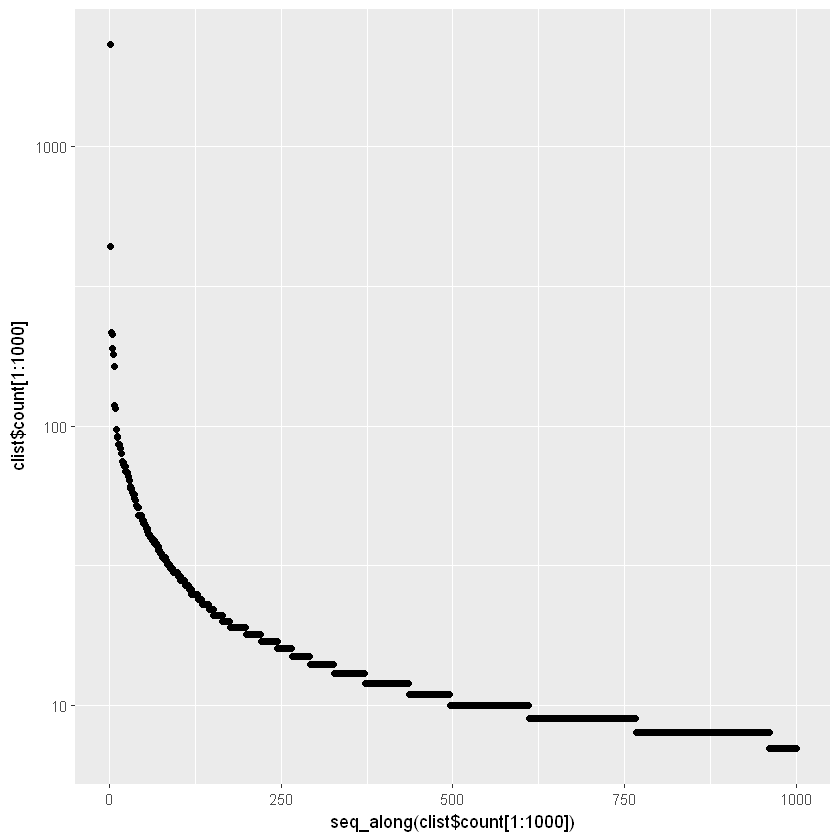

In [57]:
qplot(y=clist$count[1:1000],log="y")

It looks like most of our client subnets have only one or two queries. The number of subnets with more than one query (out of a total of 29,277)  are as follows.

In [59]:
nrow(clist[clist$count>1,])

[1] 9702

## Average RTT exploration

Now looking at the average round trip times.

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   1.287   48.150   96.530  172.000  195.000 4676.000 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
"Transformation introduced infinite values in continuous y-axis"Warning message:
"Removed 4 rows containing missing values (geom_bar)."

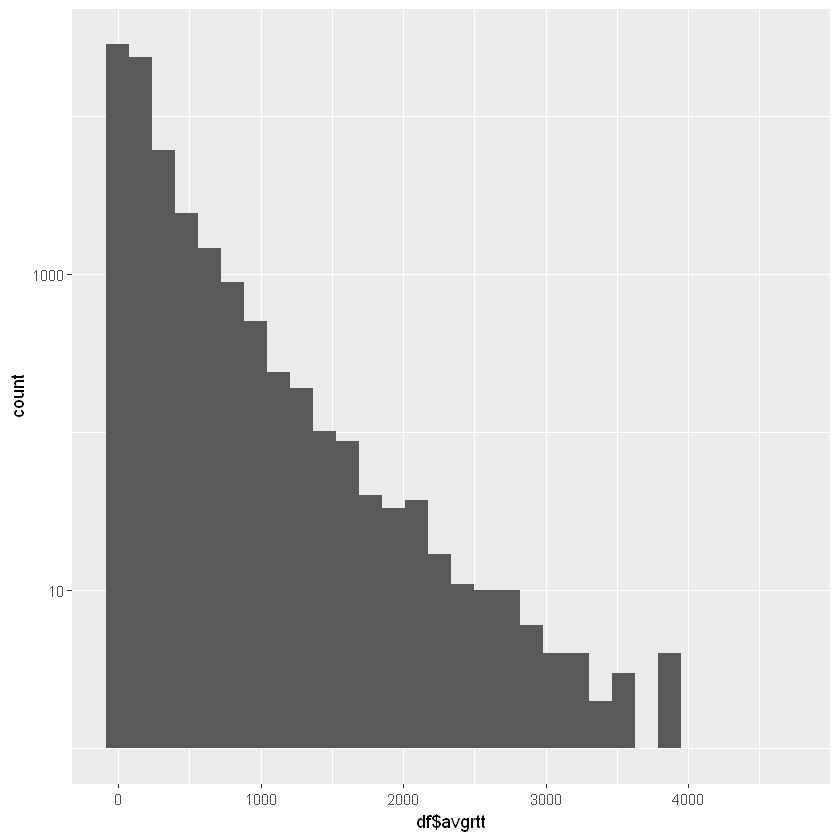

In [61]:
summary(df$avgrtt)
qplot(x = df$avgrtt, geom = "histogram",log="y") 

It looks like there is a 1/f-like distribution of round trip times with most of them coming in short, but with a few longer times. Those may be outliers.

I'm going to create a factor to color the average round trip time based on the log of the value - that gives us colors ranging from very short times to very long times.

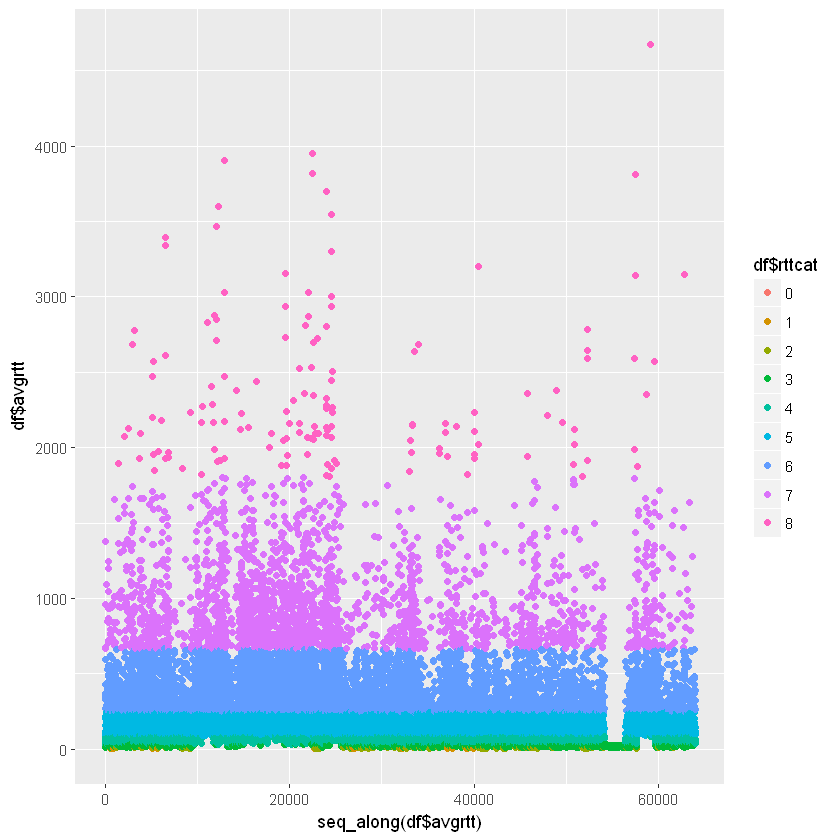

In [63]:
df$rttcat<-factor(round(log(df$avgrtt)))
qplot(y=df$avgrtt,color=df$rttcat)

Is there a geographic dependence on the average rtt? Plotting this on a world map and looking for the lighter red/pink values, using this same coloring.

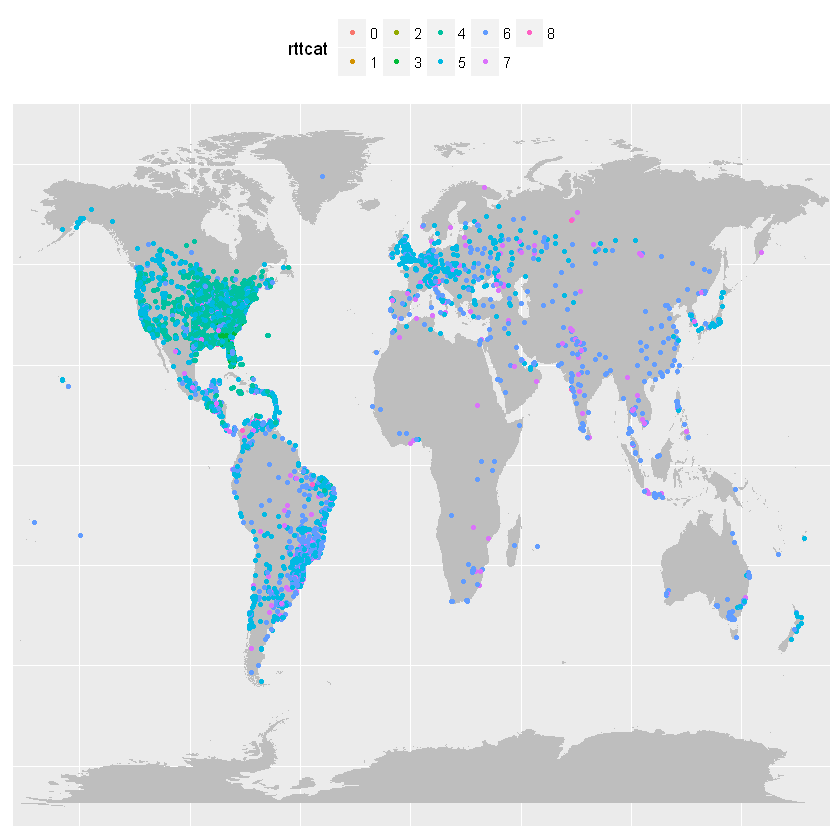

In [65]:
world_data <- map_data("world")

p<-ggplot() + scale_y_continuous(limits=c(-90,90), expand=c(0,0)) +
    scale_x_continuous(expand=c(0,0)) +
    theme(axis.ticks=element_blank(), axis.title=element_blank(),
      axis.text=element_blank()) +
    geom_polygon(data=world_data, mapping=aes(x=long, y=lat, group=group), fill='grey') 
p + geom_point(aes(x = clientlon, y = clientlat, color=rttcat),size=1, data = df)+
theme(legend.position = "top") +
  scale_size(range=c(0.1,1))

It doesn't look like there is a very clear pattern predicting from where the long average rtt times are coming. There are more short times coming from the USA, but it isn't a definate pattern.

## Outlier Exploration

Finally, I explore the outlier prediction to see what it looks like. I'll plot average rtt and color by outlier status.

In [74]:
df$outlierfac <-factor(1-df$outlier)
levels(df$outlierfac)<-c("Outlier","Normal")
str(df$outlierfac)

 Factor w/ 2 levels "Outlier","Normal": 2 2 2 2 2 2 2 2 2 2 ...


Keeping only the top 10 client subnets for plotting.

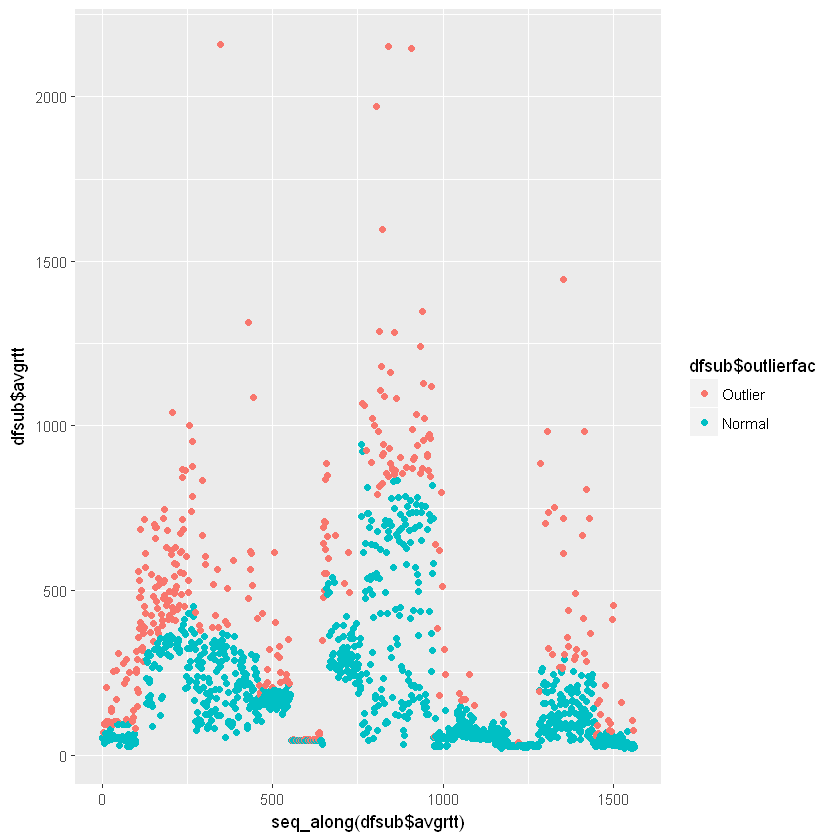

In [79]:
dfsub = df[df$clientsub %in% clist$clientsub[3:13],]
dfsub <- dfsub[with(dfsub, order(clientsub,daytime)), ]
qplot(y=dfsub$avgrtt,color=dfsub$outlierfac)

It looks like the algorithm is doing what it is supposed to: flagging the high average rtt values as outliers.

Last, I save the data for importing in Hive

In [80]:
dfout <- df[,c('daytime','serverip','clientip','clientport','clientlat','clientlon',
  'sumrtt','countrtt','avgrtt','ninsub','avginsub','sigmainsub','datafreq',
  'outlier','dataday','clientsub')]
dfout<-dfout[with(dfout, order(dataday)), ]
write.table(dfout,file='processed_combined_data.csv',row.names=FALSE, col.names=FALSE,quote=FALSE,sep=",")